In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from acquire import get_telco_data

In [2]:
df = get_telco_data()

In [3]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn
0,0002-ORFBO,Female,0,Yes,Yes,9,65.6,593.3,Yes,No,...,Yes,No,Yes,Yes,No,Yes,2,2,1,No
1,0003-MKNFE,Male,0,No,No,9,59.9,542.4,Yes,Yes,...,No,No,No,No,Yes,No,1,2,1,No
2,0004-TLHLJ,Male,0,No,No,4,73.9,280.85,Yes,No,...,No,Yes,No,No,No,Yes,1,1,2,Yes
3,0011-IGKFF,Male,1,Yes,No,13,98.0,1237.85,Yes,No,...,Yes,Yes,No,Yes,Yes,Yes,1,1,2,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,83.9,267.4,Yes,No,...,No,No,Yes,Yes,No,Yes,1,2,2,Yes


In [4]:
df.shape

(7043, 21)

In [5]:
# Check for nulls in the columns of interest
assert df.total_charges.isna().sum() == 0, "There are missing values in this column. Handle them before proceeding"
assert df.monthly_charges.isna().sum() == 0, "There are missing values in this column. Handle them before proceeding"
assert df.tenure.isna().sum() == 0, "There are missing values in this column. Handle them before proceeding"

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
monthly_charges             7043 non-null float64
total_charges               7043 non-null float64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
contract_type_id            7043 non-null int64
payment_type

In [7]:
#why is total_charges an object?
df.total_charges.value_counts(dropna=False)

20.2       11
           11
19.75       9
19.65       8
19.9        8
           ..
54.65       1
2879.2      1
1752.65     1
779.25      1
2614.1      1
Name: total_charges, Length: 6531, dtype: int64

- It looks like there are 11 observations where the total_charges is an empty string
- Need to change total_charges to a float

In [8]:
# Make any string with multiple spaces into an empty space value
df.total_charges = df.total_charges.str.strip()

# Count the number of empty string entries
df[df.total_charges == ""]

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn
945,1371-DWPAZ,Female,0,Yes,Yes,0,56.05,,No,No phone service,...,Yes,Yes,Yes,Yes,No,No,3,4,1,No
1731,2520-SGTTA,Female,0,Yes,Yes,0,20.00,,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,3,2,3,No
1906,2775-SEFEE,Male,0,No,Yes,0,61.90,,Yes,Yes,...,Yes,No,Yes,No,No,Yes,3,3,1,No
2025,2923-ARZLG,Male,0,Yes,Yes,0,19.70,,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Yes,2,2,3,No
2176,3115-CZMZD,Male,0,No,Yes,0,20.25,,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,3,2,3,No
2250,3213-VVOLG,Male,0,Yes,Yes,0,25.35,,Yes,Yes,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,3,2,3,No
2855,4075-WKNIU,Female,0,Yes,Yes,0,73.35,,Yes,Yes,...,Yes,Yes,Yes,Yes,No,No,3,2,1,No
3052,4367-NUYAO,Male,0,Yes,Yes,0,25.75,,Yes,Yes,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,3,2,3,No
3118,4472-LVYGI,Female,0,Yes,Yes,0,52.55,,No,No phone service,...,No,Yes,Yes,Yes,No,Yes,3,3,1,No
4054,5709-LVOEQ,Female,0,Yes,Yes,0,80.85,,Yes,No,...,Yes,Yes,No,Yes,Yes,No,3,2,1,No


It looks like those values are blank bc the tenure is 0. I will change it to 1 since they were probably customers for about a month

In [9]:
df.tenure.value_counts().sort_index()

0      11
1     613
2     238
3     200
4     176
     ... 
68    100
69     95
70    119
71    170
72    362
Name: tenure, Length: 73, dtype: int64

In [10]:
# Replace any tenures of 0 with 1

df.tenure.replace(0, 1, inplace=True)
# # Validate my tenure count for value 1

df.tenure.value_counts().sort_index()

1     624
2     238
3     200
4     176
5     133
     ... 
68    100
69     95
70    119
71    170
72    362
Name: tenure, Length: 72, dtype: int64

In [11]:
df[df.tenure == 1]

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn
17,0021-IKXGC,Female,1,No,No,1,72.10,72.1,Yes,Yes,...,No,No,No,No,No,Yes,1,1,2,No
19,0023-HGHWL,Male,1,No,No,1,25.10,25.1,No,No phone service,...,No,No,No,No,No,Yes,1,1,1,Yes
25,0032-PGELS,Female,0,Yes,Yes,1,30.50,30.5,No,No phone service,...,No,No,No,No,No,No,1,3,1,Yes
48,0082-LDZUE,Male,0,No,No,1,44.30,44.3,Yes,No,...,No,No,No,No,No,Yes,1,2,1,No
63,0107-WESLM,Male,0,No,No,1,19.85,19.85,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Yes,1,1,3,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6980,9907-SWKKF,Female,1,No,No,1,25.05,25.05,No,No phone service,...,No,No,No,No,No,No,1,2,1,Yes
7007,9940-RHLFB,Female,0,No,No,1,75.30,75.3,Yes,No,...,No,Yes,No,No,No,No,1,1,2,Yes
7021,9962-BFPDU,Female,0,Yes,Yes,1,20.05,20.05,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,1,2,3,No
7033,9975-SKRNR,Male,0,No,No,1,18.90,18.9,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,1,2,3,No


In [12]:
# Replace the blank total_charges with the monthly_charge for tenure == 1
df.total_charges.replace('', df.monthly_charges, inplace=True)

In [13]:
# Validate my changes
df[df.tenure == 1]

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn
17,0021-IKXGC,Female,1,No,No,1,72.10,72.1,Yes,Yes,...,No,No,No,No,No,Yes,1,1,2,No
19,0023-HGHWL,Male,1,No,No,1,25.10,25.1,No,No phone service,...,No,No,No,No,No,Yes,1,1,1,Yes
25,0032-PGELS,Female,0,Yes,Yes,1,30.50,30.5,No,No phone service,...,No,No,No,No,No,No,1,3,1,Yes
48,0082-LDZUE,Male,0,No,No,1,44.30,44.3,Yes,No,...,No,No,No,No,No,Yes,1,2,1,No
63,0107-WESLM,Male,0,No,No,1,19.85,19.85,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Yes,1,1,3,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6980,9907-SWKKF,Female,1,No,No,1,25.05,25.05,No,No phone service,...,No,No,No,No,No,No,1,2,1,Yes
7007,9940-RHLFB,Female,0,No,No,1,75.30,75.3,Yes,No,...,No,Yes,No,No,No,No,1,1,2,Yes
7021,9962-BFPDU,Female,0,Yes,Yes,1,20.05,20.05,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,1,2,3,No
7033,9975-SKRNR,Male,0,No,No,1,18.90,18.9,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No,1,2,3,No


In [14]:
df.total_charges = df.total_charges.astype(float)

In [15]:
def wrangle_telco():
    df = acquire.get_telco_data()
    df.tenure.replace(0, 1, inplace=True)
    df.total_charges = df.total_charges.str.strip()
    df.total_charges.replace('', df.monthly_charges, inplace=True)
    df.total_charges = df.total_charges.astype(float)
    return df

In [16]:
# step 1 split
train, test = train_test_split(df, random_state=123, train_size=.86)
train, validate = train_test_split(train, random_state=123, train_size=.83)

In [17]:
# step 2 for loop w/ list of columns to encode
encoder = LabelEncoder()

encode_list = [
    'gender', 'partner', 'dependents', 'phone_service'
    , 'multiple_lines', 'online_security', 'online_backup'
    , 'device_protection', 'tech_support'
    , 'streaming_movies', 'streaming_tv', 'paperless_billing', 'churn'
    ]
               
               
               
for e in encode_list:
    train[e] = encoder.fit_transform(train[e])
    test[e] = encoder.transform(test[e])

In [18]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn
4782,6728-DKUCO,0,0,1,1,72,104.15,7303.05,1,2,...,2,0,0,2,2,1,2,1,2,0
3552,5032-USPKF,0,0,0,0,38,84.10,3187.65,1,2,...,2,2,0,2,2,0,2,3,1,0
1688,2460-NGXBJ,1,1,1,1,11,75.20,775.30,1,2,...,0,0,0,0,0,1,1,4,2,0
3210,4603-JANFB,1,0,0,0,1,69.85,69.85,1,0,...,0,0,0,0,0,1,1,1,2,1
2647,3761-FLYZI,0,1,1,0,65,108.80,7082.45,1,2,...,2,2,0,2,2,1,1,3,2,0


In [19]:
train.shape

(5026, 21)

In [20]:
test.shape

(987, 21)

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5026 entries, 4782 to 4315
Data columns (total 21 columns):
customer_id                 5026 non-null object
gender                      5026 non-null int64
senior_citizen              5026 non-null int64
partner                     5026 non-null int64
dependents                  5026 non-null int64
tenure                      5026 non-null int64
monthly_charges             5026 non-null float64
total_charges               5026 non-null float64
phone_service               5026 non-null int64
multiple_lines              5026 non-null int64
online_security             5026 non-null int64
online_backup               5026 non-null int64
device_protection           5026 non-null int64
tech_support                5026 non-null int64
streaming_tv                5026 non-null int64
streaming_movies            5026 non-null int64
paperless_billing           5026 non-null int64
contract_type_id            5026 non-null int64
payment_type_id      

In [22]:
# How many people have churned?
train.churn.value_counts()

0    3706
1    1320
Name: churn, dtype: int64

Let's try to narrow down which features have an effect on churn
try a .corr 

In [23]:
train.corr()

,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn
gender,1.000000,-0.004663,-0.007578,0.016105,-0.003627,-0.020876,-0.010098,0.000425,-0.017346,-0.012186,-0.022398,0.004285,-0.009498,-0.004764,-0.004436,-0.019429,0.003868,-0.005449,0.001040,-0.004412
senior_citizen,-0.004663,1.000000,0.017866,-0.208910,0.009552,0.220709,0.096819,0.011648,0.139979,-0.125236,-0.004461,-0.031011,-0.149980,0.024609,0.038489,0.152232,-0.144449,-0.089539,-0.027149,0.150677
partner,-0.007578,0.017866,1.000000,0.442386,0.384309,0.125799,0.330268,0.029932,0.160946,0.129755,0.156249,0.149445,0.125166,0.143017,0.134767,0.003150,0.287108,0.138370,-0.007884,-0.145413
dependents,0.016105,-0.208910,0.442386,1.000000,0.162196,-0.103421,0.066173,0.001268,-0.017779,0.136732,0.078686,0.067737,0.126025,0.044739,0.026201,-0.108924,0.237651,0.136012,0.032273,-0.164659
tenure,-0.003627,0.009552,0.384309,0.162196,1.000000,0.252960,0.827702,0.015866,0.345716,0.329188,0.379456,0.358512,0.325898,0.285212,0.294898,0.020344,0.672822,0.333982,-0.031001,-0.356516
monthly_charges,-0.020876,0.220709,0.125799,-0.103421,0.252960,1.000000,0.654077,0.244360,0.432819,-0.054794,0.123092,0.165367,0.002501,0.327965,0.339230,0.354714,-0.070806,-0.077827,-0.322427,0.192220
total_charges,-0.010098,0.096819,0.330268,0.066173,0.827702,0.654077,1.000000,0.115594,0.455608,0.254908,0.382655,0.377140,0.283258,0.384166,0.397820,0.168335,0.449305,0.217945,-0.176332,-0.203565
phone_service,0.000425,0.011648,0.029932,0.001268,0.015866,0.244360,0.115594,1.000000,-0.023924,-0.021123,0.016128,0.001735,-0.018417,0.051544,0.051769,0.010544,-0.002758,-0.013222,0.378922,0.015050
multiple_lines,-0.017346,0.139979,0.160946,-0.017779,0.345716,0.432819,0.455608,-0.023924,1.000000,0.008721,0.126430,0.115874,0.011261,0.164579,0.179023,0.164503,0.112203,0.036874,-0.114085,0.029163
online_security,-0.012186,-0.125236,0.129755,0.136732,0.329188,-0.054794,0.254908,-0.021123,0.008721,1.000000,0.184695,0.172348,0.283303,0.045946,0.047845,-0.153390,0.373992,0.239419,-0.037749,-0.296673


Which contract type has the highest number of people churning?

In [25]:
train.groupby(['churn']).contract_type_id.value_counts()

churn  contract_type_id
0      1                   1574
       3                   1194
       2                    938
1      1                   1183
       2                    104
       3                     33
Name: contract_type_id, dtype: int64

In [26]:
train.groupby(['contract_type_id', 'churn']).tenure.count().nlargest()

contract_type_id  churn
1                 0        1574
3                 0        1194
1                 1        1183
2                 0         938
                  1         104
Name: tenure, dtype: int64

- It looks like the highest number of people who have churned have a month to month contract and they tend to churn just after the first month.
- why?

In [27]:
#Does the churn group buy more of one specific type of internet?
train.groupby(['churn']).internet_service_type_id.value_counts()

churn  internet_service_type_id
0      1                           1412
       2                           1285
       3                           1009
1      2                            921
       1                            327
       3                             72
Name: internet_service_type_id, dtype: int64

In [28]:
train.groupby(['churn']).payment_type_id.value_counts()

churn  payment_type_id
0      2                  929
       3                  929
       4                  926
       1                  922
1      1                  749
       2                  220
       3                  182
       4                  169
Name: payment_type_id, dtype: int64

In [29]:
train.groupby(['churn','contract_type_id']).payment_type_id.value_counts()

churn  contract_type_id  payment_type_id
0      1                 1                  612
                         2                  428
                         3                  277
                         4                  257
       2                 4                  255
                         3                  251
                         2                  232
                         1                  200
       3                 4                  414
                         3                  401
                         2                  269
                         1                  110
1      1                 1                  704
                         2                  208
                         3                  143
                         4                  128
       2                 1                   37
                         4                   31
                         3                   26
                         2                   10

- It looks like the non-automatic payment types account for the highest number of people who have churned.
- I would like to do some feature engineering that groups payment type into automatic and manual

In [30]:
df1 = train[['churn','contract_type_id', 'payment_type_id']]

In [31]:
df1.head()

,churn,contract_type_id,payment_type_id
4782,0,2,1
3552,0,2,3
1688,0,1,4
3210,1,1,1
2647,0,1,3


In [32]:
melt = df1.melt(id_vars=['churn','contract_type_id'], value_name='payment_mode')
melt.index=train.index

In [33]:
melt.head()

,churn,contract_type_id,variable,payment_mode
4782,0,2,payment_type_id,1
3552,0,2,payment_type_id,3
1688,0,1,payment_type_id,4
3210,1,1,payment_type_id,1
2647,0,1,payment_type_id,3


In [50]:
train['automatic_payment'] = ((df['payment_type_id'] == 3) | (df['payment_type_id'] == 4))

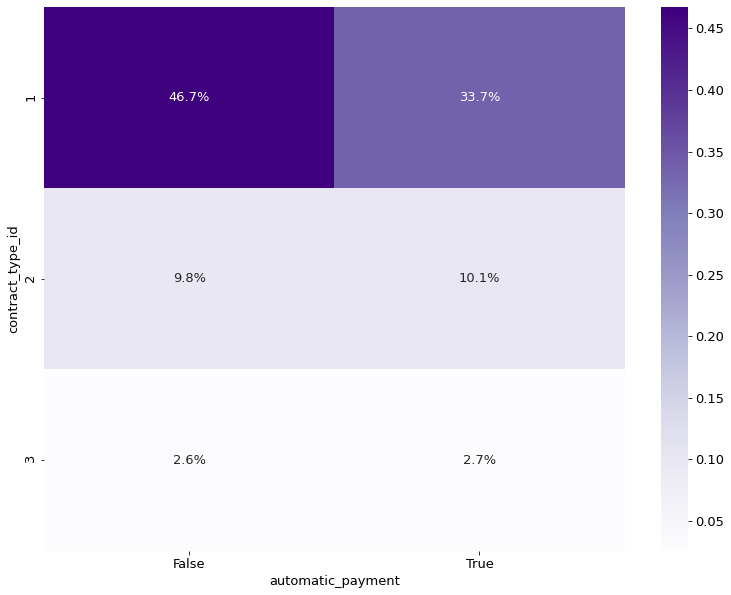

In [52]:
plt.rc('figure', figsize=(13, 10))
plt.rc('font', size=13)
ctab = pd.crosstab(train.contract_type_id, train.automatic_payment, values=train.churn, aggfunc='mean')
sns.heatmap(ctab, annot=True, cmap='Purples', fmt='.1%')